<a href="https://colab.research.google.com/github/MehrdadJannesar/CNN_AdaBoost/blob/master/Stacking_Final_Edition_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import datetime
import tensorflow as tf
import keras
import pandas as pd
from keras.datasets import imdb
from keras.models import Sequential
from keras import callbacks
from keras.models import Model
from keras import backend as K 
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.layers import Embedding,Dropout,Conv1D,GlobalMaxPooling1D,Dense,Activation,LSTM,Bidirectional,GRU,SpatialDropout1D
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
import numpy as np  
import matplotlib.pyplot as plt

Using TensorFlow backend.


### IMDB dataset
Dataset of 25,000 movies reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes (integers). For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data. This allows for quick filtering operations such as: "only consider the top 10,000 most common words, but eliminate the top 20 most common words".

As a convention, "0" does not stand for a specific word, but instead is used to encode any unknown word.

In [0]:
np_load_old = np.load

np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

top_words = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)
np.load = np_load_old

In [0]:
max_review_length = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

Lets take a look on item 0 of this data

In [0]:
print(X_train[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

What we see is a list of integers. Each integer represents one word in a movie review. That is, our movie review has been converted to a list of integers. Each word in our movie review vocabulary has been indexed by a unique integer. Here is the text of an example review from our dataset:

![alt text](https://doc-04-88-docs.googleusercontent.com/docs/securesc/v903qu5s530pc8ikhnbi48s9q8im2q6p/a6erdvhp4mldhk5sadsrog9htsr3ee4j/1578045600000/06997921430171725257/06997921430171725257/1I5goN4ysCg3tpRaFsD6kWXGWctc_eCa3?authuser=0&nonce=f9miihtf852ng&user=06997921430171725257&hash=u3ddgf6kbjosr7migquhiii1ijrqlp8u)

A simple parsing and indexing can map each word in our movie review database to a unique integer like in this example:



![alt text](https://doc-10-88-docs.googleusercontent.com/docs/securesc/v903qu5s530pc8ikhnbi48s9q8im2q6p/ae6pvisvlotc5o30u6i6kqj6jshub7hl/1578045600000/06997921430171725257/06997921430171725257/13TqT_hNI9YjsveBtCOy1rElefgarp4R7?authuser=0)
It should be noted that only words with a minimal level of frequency are entering the vocabulary. Words with low frequency are simply ignored (and are masked by index 0). This process is described in Yoon Kim's paper above and also in this tutorial:
http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/

#### ref: https://www.samyzaf.com/ML/imdb/imdb.html

### Stacking

Stacking is an ensemble learning technique that combines multiple classification or regression models via a meta-classifier or a meta-regressor. The base level models are trained based on a complete training set, then the meta-model is trained on the outputs of the base level model as features.
The base level often consists of different learning algorithms and therefore stacking ensembles are often heterogeneous. The algorithm below summarizes stacking.

![alt text](https://doc-00-88-docs.googleusercontent.com/docs/securesc/v903qu5s530pc8ikhnbi48s9q8im2q6p/mme8k72mi5u80iiavntmu9e1gkp2vg5s/1578045600000/06997921430171725257/06997921430171725257/1IljNsOdNGSz4bdwH4l86CIHmLwO0JTpZ?authuser=0)

The following accuracy is visualized in the top right plot of the figure above:
Accuracy: 0.91 (+/- 0.01) [KNN]
Accuracy: 0.91 (+/- 0.06) [Random Forest]
Accuracy: 0.92 (+/- 0.03) [Naive Bayes]
Accuracy: 0.95 (+/- 0.03) [Stacking Classifier]
The stacking ensemble is illustrated in the figure above. It consists of k-NN, Random Forest, and Naive Bayes base classifiers whose predictions are combined by Logistic Regression as a meta-classifier. We can see the blending of decision boundaries achieved by the stacking classifier. The figure also shows that stacking achieves higher accuracy than individual classifiers and based on learning curves, it shows no signs of overfitting.
Stacking is a commonly used technique for winning the Kaggle data science competition. For example, the first place for the Otto Group Product Classification challenge was won by a stacking ensemble of over 30 models whose output was used as features for three meta-classifiers: XGBoost, Neural Network, and Adaboost. See the following link for details.

## Define function for visualization metrics

#### Build a text report showing the main classification metrics

The reported averages include macro average (averaging the unweighted mean per label), weighted average (averaging the support-weighted mean per label), sample average (only for multilabel classification) and micro average (averaging the total true positives, false negatives and false positives) it is only shown for multi-label or multi-class with a subset of classes because it is accuracy otherwise. See also precision_recall_fscore_support for more details on averages.

Note that in binary classification, recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”.

Read more in the User Guide:

#### ref: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

In [0]:
def plot_classification_report(y_tru, y_prd, figsize=(18, 10), ax=None, cmap = "RdBu_r"):

    plt.figure(figsize=figsize)

    xticks = ['precision', 'recall', 'f1-score', 'support']
    yticks = list(np.unique(y_tru))
    yticks += ['avg']

    rep = np.array(precision_recall_fscore_support(y_tru, y_prd)).T
    avg = np.mean(rep, axis=0)
    avg[-1] = np.sum(rep[:, -1])
    rep = np.insert(rep, rep.shape[0], avg, axis=0)

    sns.heatmap(rep,
                annot=True, 
                cbar=True, 
                xticklabels=xticks, 
                yticklabels=yticks,
                 linewidths=.5,
                 cmap=cmap,
                ax=ax)

## MODELS

### Define default parameters

In [0]:
max_features = 5000
embedding_dims = 50
maxlen = 500
batch_size = 32
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 2
embedding_vecor_length = 32
units = 128

### 1-D Convolutions over text
Given a sequence of words w1:n=w1,…,wn, where each is associated with an embedding vector of dimension d. A 1D convolution of width-k is the result of moving a sliding-window of size k over the sentence, and applying the same convolution filter or kernel to each window in the sequence, i.e., a dot-product between the concatenation of the embedding vectors in a given window and a weight vector u, which is then often followed by a non-linear activation function g.

Considering a window of words wi,…,wi+k the concatenated vector of the ith window is then:

xi=[wi,wi+1,…,wi+k]∈R k × d
The convolution filter is applied to each window, resulting in scalar values ri, each for the ith window:

ri=g(xi⋅u)∈R
In practice one typically applies more filters, u1,…,ul, which can then be represented as a vector multiplied by a matrix U and with an addition of a bias term b:

ri=g(xi⋅U+b)

with ri∈Rl,   xi∈R k × d,   U∈R k ⋅ d ×l   and   b∈Rl
An example of a sentence convolution in a vector-concatenation notation:

![alt text](https://doc-0o-88-docs.googleusercontent.com/docs/securesc/v903qu5s530pc8ikhnbi48s9q8im2q6p/qbaqeqgjm0r4o27mqjvb2ablm5eidrjr/1578045600000/06997921430171725257/06997921430171725257/1oD3TnI8j_3NIiKH-J3ng8n9J4Kb3Gd6j?authuser=0)

Example of a sentence convolution with k=2 and dimensional output l=3.
(Image adapted from Yoav Goldberg book "Neural Network Methods for NLP")

### K-Fold
We use the scikit-learn library to implementation of K-fold data. That will split a given data. It takes as arguments the number of splits(fold) and to shuffle the sample or not.

The split() will return each group of the train and test sets. The returned array contains the indexes of the original data sample of observations to use for train and test sets on each iteration.
![alt text](https://camo.githubusercontent.com/a802017ecb2ebd2aeeaa601a81ca921a1979fdd4/68747470733a2f2f69302e77702e636f6d2f616e64726f69646b742e636f6d2f77702d636f6e74656e742f75706c6f6164732f323031392f30382f6b2d666f6c642d76616c69646174696f6e2e706e673f726573697a653d3736382532433230312673736c3d31)

Define sets like fold 1,2 3 and you conduct 3 experiments. In each of the experiments, the fold i is used for assessment and the other folds are merged together for training. For experiment 1, I hold out fold 1 for testing and train on 2 and 3, and I get a number.

ref:https://androidkt.com/k-fold-cross-validation-with-tensorflow-keras/

#### ====================================
## Text CNN Model
#### ====================================

###  Define Model

In [0]:
def fit_model_text_CNN(optimizer='adam'):
    model_text_CNN = Sequential()


    model_text_CNN.add(Embedding(max_features,
                      embedding_dims,
                      input_length=maxlen))
    model_text_CNN.add(Dropout(0.2))

    model_text_CNN.add(Conv1D(filters,
                      kernel_size,
                      padding='SAME',
                      activation='relu',
                      strides=1))
    model_text_CNN.add(GlobalMaxPooling1D())
    
    model_text_CNN.add(Dense(hidden_dims))
    model_text_CNN.add(Dropout(0.2))
    model_text_CNN.add(Activation('relu'))
    
    model_text_CNN.add(Dense(1))
    model_text_CNN.add(Activation('sigmoid'))
    
    model_text_CNN.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])
    # Plot Model
    plot_model(model_text_CNN, to_file = 'D:/TrainingModels/Model_text_CNN/model_text_CNN.png',show_shapes=True)
    
    return model_text_CNN

## Text CNN Graph Model :
![alt text](https://doc-14-88-docs.googleusercontent.com/docs/securesc/v903qu5s530pc8ikhnbi48s9q8im2q6p/rabre36tndmabkldpaac5dq6r60gj4bj/1578045600000/06997921430171725257/06997921430171725257/1rb0imiYiIhx5-M9WGR6o81y6OCbDdzUi?authuser=0)

### Fit Model

In [0]:
n_split=3
pred_ls_model_1 = np.array([])
Y_target = np.array([])
i = 0

# Callbacks Model
model_checkpoint = callbacks.ModelCheckpoint('D:/TrainingModels/Model_text_CNN/model_checkpoint.{epoch}.h5')
model_logger = callbacks.CSVLogger('D:/TrainingModels/Model_text_CNN/training_log.log')
tensorboard = callbacks.TensorBoard(log_dir = 'D:/TrainingModels/Model_text_CNN/tensorboard')
call_backs = [model_checkpoint,model_logger,tensorboard]

model=fit_model_text_CNN()

start = datetime.datetime.now()

for train_index,test_index in KFold(n_split).split(X_train):

    x_train, x_test, Y_train, Y_test = X_train[train_index], X_test[test_index], y_train[train_index], y_test[test_index]
    Y_target = np.append(Y_target,Y_test)
    model.fit(x_train, Y_train,epochs=20,batch_size=128,
             callbacks=call_backs,
             validation_data=(x_test, Y_test))
    
    pred_ls_model_1 = np.append(pred_ls_model_1,model.predict(x_test))
    i = i + 1

# predict probabilities for test set
p1_probs = model.predict(X_test, verbose=0)
# predict crisp classes for test set
p1_classes = model.predict_classes(X_test, verbose=0)

# reduce to 1d array
p1_probs = p1_probs[:, 0]
p1_classes = p1_classes[:, 0]

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, p1_classes)
print('Accuracy of model : %f' % accuracy)


end = datetime.datetime.now()

elapsed = end-start
# Save Model
model.save('D:/TrainingModels/Model_text_CNN/Model_text_CNN.h5')
model.save_weights('D:/TrainingModels/Model_text_CNN/Model_text_CNN_Weights.h5')

print(25*"=")
print("Total training time: ", str(elapsed))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 16666 samples, validate on 8334 samples


Epoch 1/20
16666/16666 [==============================] - 10s 621us/step - loss: 0.5785 - acc: 0.6655 - val_loss: 0.3634 - val_acc: 0.8411
Epoch 2/20
16666/16666 [==============================] - 9s 523us/step - loss: 0.3035 - acc: 0.8742 - val_loss: 0.2887 - val_acc: 0.8792
Epoch 3/20
16666/16666 [==============================] - 9s 524us/step - loss: 0.2041 - acc: 0.9203 - val_loss: 0.2939 - val_acc: 0.8790
Epoch 4/20
16666/16666 [==============================] - 9s 524us/step - loss: 0.1481 - acc: 0.9444 - val_loss: 0.3309 - val_acc: 0.8686
Epoch 5/20
16666/16666 [==============================] - 9s 524us/step - loss: 0.1002 - acc: 0.9650 - val_loss: 0.3244 - val_acc: 0.8802
Epoch 6/20
16666/16666 [===================

## Loss and Accuracy for each epoch:

![alt text](https://doc-0s-88-docs.googleusercontent.com/docs/securesc/v903qu5s530pc8ikhnbi48s9q8im2q6p/su30pa4t8b6sfrku5qmv5k0jeips5pbd/1578045600000/06997921430171725257/06997921430171725257/10EMUupNYFLaCXojBK-C6A2uq6zjqheBq?authuser=0)

## Report metric model:

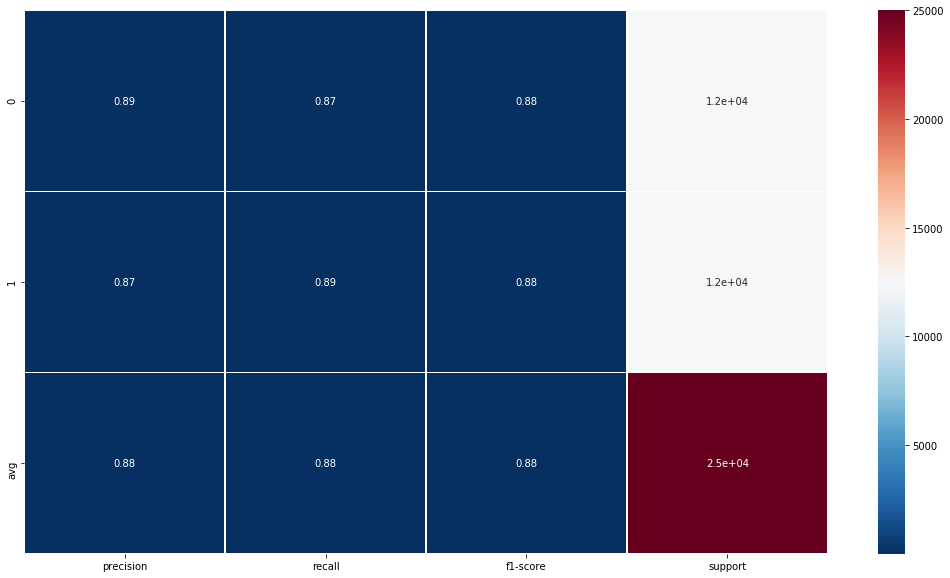

In [0]:
plot_classification_report(y_test, p1_classes)

#### ====================================
## LSTM Model
#### ====================================

### Define Model

In [0]:
def fit_model_L(optimizer='Adam'):

    model_L = Sequential()
    model_L.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
    model_L.add(SpatialDropout1D(0.3))
    model_L.add(LSTM(128, dropout = 0.3))
    model_L.add(Dropout(0.3))
    model_L.add(Dense(1, activation = 'sigmoid'))
    model_L.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    
    # Plot Model
    plot_model(model_L, to_file = 'D:/TrainingModels/Model_LSTM/Model_LSTM.png',show_shapes=True)
    return model_L


## LSTM Graph Model:

![alt text](https://doc-10-88-docs.googleusercontent.com/docs/securesc/v903qu5s530pc8ikhnbi48s9q8im2q6p/4qsci2ed50n3dnbov1epr3rcvnvbhnqm/1578045600000/06997921430171725257/06997921430171725257/1efMZNYSkb_703Zi82KDp6G4V57ogWQ6n?authuser=0)

### Fit Model

In [0]:
n_split=3
pred_ls_model_2 = np.array([])
i = 0


# Callbacks Model
model_checkpoint = callbacks.ModelCheckpoint('D:/TrainingModels/Model_LSTM/model_checkpoint.{epoch}.h5')
model_logger = callbacks.CSVLogger('D:/TrainingModels/Model_LSTM/training_log.log')
tensorboard = callbacks.TensorBoard(log_dir = 'D:/TrainingModels/Model_LSTM/tensorboard')
call_backs = [model_checkpoint,model_logger,tensorboard]

model=fit_model_L()

start = datetime.datetime.now()
for train_index,test_index in KFold(n_split).split(X_train):


    x_train, x_test, Y_train, Y_test = X_train[train_index], X_test[test_index], y_train[train_index], y_test[test_index]
    
    model.fit(x_train, Y_train,epochs=20,batch_size=256,
              callbacks=call_backs,
             validation_data=(x_test, Y_test))
    
    pred_ls_model_2 = np.append(pred_ls_model_2,model.predict(x_test))
    i = i + 1

# predict probabilities for test set
p2_probs = model.predict(X_test, verbose=0)
# predict crisp classes for test set
p2_classes = model.predict_classes(X_test, verbose=0)

# reduce to 1d array
p2_probs = p2_probs[:, 0]
p2_classes = p2_classes[:, 0]

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, p2_classes)
print('Accuracy of model : %f' % accuracy)


end = datetime.datetime.now()

elapsed = end-start

# Save Model
model.save('D:/TrainingModels/Model_LSTM/Model_LSTM.h5')
model.save_weights('D:/TrainingModels/Model_LSTM/Model_LSTM_Weights.h5')

print(25*"=")
print("Total training time: ", str(elapsed))


Train on 16666 samples, validate on 8334 samples
Epoch 1/20
16666/16666 [==============================] - 78s 5ms/step - loss: 0.6754 - acc: 0.5698 - val_loss: 0.6527 - val_acc: 0.6313
Epoch 2/20
16666/16666 [==============================] - 77s 5ms/step - loss: 0.4891 - acc: 0.7724 - val_loss: 0.3711 - val_acc: 0.8419
Epoch 3/20
16666/16666 [==============================] - 77s 5ms/step - loss: 0.3274 - acc: 0.8637 - val_loss: 0.3013 - val_acc: 0.8762
Epoch 4/20
16666/16666 [==============================] - 77s 5ms/step - loss: 0.2549 - acc: 0.9000 - val_loss: 0.3034 - val_acc: 0.8789
Epoch 5/20
16666/16666 [==============================] - 77s 5ms/step - loss: 0.2341 - acc: 0.9078 - val_loss: 0.2995 - val_acc: 0.8753
Epoch 6/20
16666/16666 [==============================] - 77s 5ms/step - loss: 0.2183 - acc: 0.9159 - val_loss: 0.3333 - val_acc: 0.8608
Epoch 7/20
16666/16666 [==============================] - 77s 5ms/step - loss: 0.1987 - acc: 0.9237 - val_loss: 0.3381 - val_acc:

## Loss and Accuracy for each epoch:

![alt text](https://doc-0o-88-docs.googleusercontent.com/docs/securesc/v903qu5s530pc8ikhnbi48s9q8im2q6p/61smkk5vus70lc0j481kj7cvgl88sl1t/1578045600000/06997921430171725257/06997921430171725257/1iMr2S2krJqH5BE4PxymS7JpkmusuWloK?authuser=0)

## Report metric model:

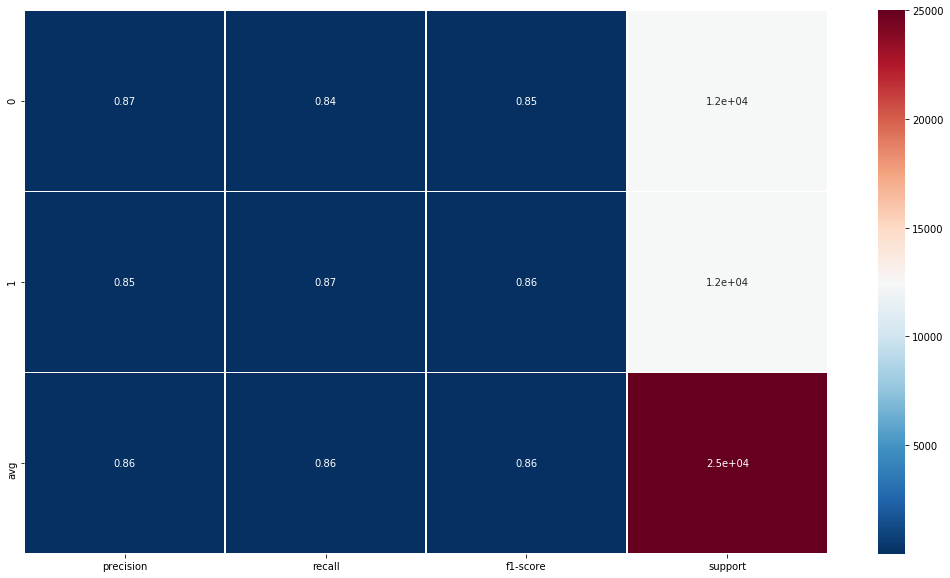

In [0]:
plot_classification_report(y_test, p2_classes)

#### ====================================
##  LSTM Attention Model
#### ====================================

### Define Model

In [0]:
def fit_model_L_A(optimizer='adam'):
    input_ = keras.layers.Input(shape=[max_review_length], dtype='int32')

  # get the embedding layer
    embedded = Embedding(
          input_dim=top_words,
          output_dim=32,
          input_length=max_review_length,
          trainable=False,
          mask_zero=False
      )(input_)

    activations = LSTM(units, return_sequences=True)(embedded)

  # compute importance for each step
    attention = Dense(1, activation='tanh')(activations)
    attention = keras.layers.Flatten()(attention)
    attention = keras.layers.Activation('softmax')(attention)
    attention = keras.layers.RepeatVector(units)(attention)
    attention = keras.layers.Permute([2, 1])(attention)

    multiply_layer = keras.layers.Multiply()
    sent_representation = multiply_layer([activations, attention])
    # sent_representation = keras.layers.Multiply([activations, attention])
    sent_representation = keras.layers.Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(units,))(sent_representation)

    probabilities = Dense(1, activation='sigmoid')(sent_representation)
    model_L_A = Model(input=input_, output=probabilities)
    model_L_A.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
    return model_L_A



###  LSTM Attention Graph Model:


![alt text](https://doc-10-88-docs.googleusercontent.com/docs/securesc/v903qu5s530pc8ikhnbi48s9q8im2q6p/t98h692ps4str2pff180ue7d2vdtrkp1/1578045600000/06997921430171725257/06997921430171725257/1ZZhwd6c_04uRnnLEUpxzL-ikyNhfKgfZ?authuser=0)

### Fit Model

In [0]:
n_split=3
pred_lsA_model = np.array([])
i = 0


# Callbacks Model
model_checkpoint = callbacks.ModelCheckpoint('D:/TrainingModels/Model_LSTM_Attention/model_checkpoint.{epoch}.h5')
model_logger = callbacks.CSVLogger('D:/TrainingModels/Model_LSTM_Attention/training_log.log')
tensorboard = callbacks.TensorBoard(log_dir = 'D:/TrainingModels/Model_LSTM_Attention/tensorboard')
call_backs = [model_checkpoint,model_logger,tensorboard]

model = fit_model_L_A()
start = datetime.datetime.now()
for train_index,test_index in KFold(n_split).split(X_train):


    x_train, x_test, Y_train, Y_test = X_train[train_index], X_test[test_index], y_train[train_index], y_test[test_index]
    
    model.fit(x_train, Y_train,epochs=20,batch_size=128,
              callbacks=call_backs,
             validation_data=(x_test, Y_test))
    
    pred_lsA_model = np.append(pred_lsA_model,model.predict(x_test))
    i = i + 1
    
    
# predict probabilities for test set
p3_probs = model.predict(X_test, verbose=0)
# predict crisp classes for test set
p3_classes =[0 if i<0.5 else 1 for i in p3_probs]

# reduce to 1d array
p3_probs = p3_probs[:, 0]

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, p3_classes)
print('Accuracy of model : %f' % accuracy)


end = datetime.datetime.now()

elapsed = end-start


# Save Model
model.save('D:/TrainingModels/Model_LSTM/Model_LSTM_Attention.h5')
model.save_weights('D:/TrainingModels/Model_LSTM/Model_LSTM_Attention_Weights.h5')

print(25*"=")
print("Total training time: ", str(elapsed))




C:\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Train on 16666 samples, validate on 8334 samples
Epoch 1/20
16666/16666 [==============================] - 135s 8ms/step - loss: 0.6932 - acc: 0.5044 - val_loss: 0.6931 - val_acc: 0.4924
Epoch 2/20
16666/16666 [==============================] - 134s 8ms/step - loss: 0.6931 - acc: 0.5059 - val_loss: 0.6932 - val_acc: 0.5076
Epoch 3/20
16666/16666 [==============================] - 133s 8ms/step - loss: 0.6929 - acc: 0.5062 - val_loss: 0.6929 - val_acc: 0.5164
Epoch 4/20
16666/16666 [==============================] - 134s 8ms/step - loss: 0.6929 - acc: 0.5137 - val_loss: 0.6940 - val_acc: 0.4924
Epoch 5/20
16666/16666 [==============================] - 134s 8ms/step - loss: 0.6951 - acc: 0.5123 - val_loss: 0.6929 - val_acc: 0.4950
Epoch 6/20
16666/16666 [==============================] - 133s 8ms/step - loss: 0.6926 - acc: 0.5154 - val_loss: 0.6920 - val_acc: 0.5401
Epoch 7/20
16666/16666 [==============================] - 135s 8ms/step - loss: 0.6928 - acc: 0.5143 - val_loss: 0.6927 - v

## Loss and Accuracy for each epoch
![alt text](https://doc-0k-88-docs.googleusercontent.com/docs/securesc/v903qu5s530pc8ikhnbi48s9q8im2q6p/3t2sv75vto3pgoova6r62qigne390hk6/1578045600000/06997921430171725257/06997921430171725257/1ZmyU1loJQuLReb4t3NASIiip8cfIKYsj?authuser=0)

## Report metric model:

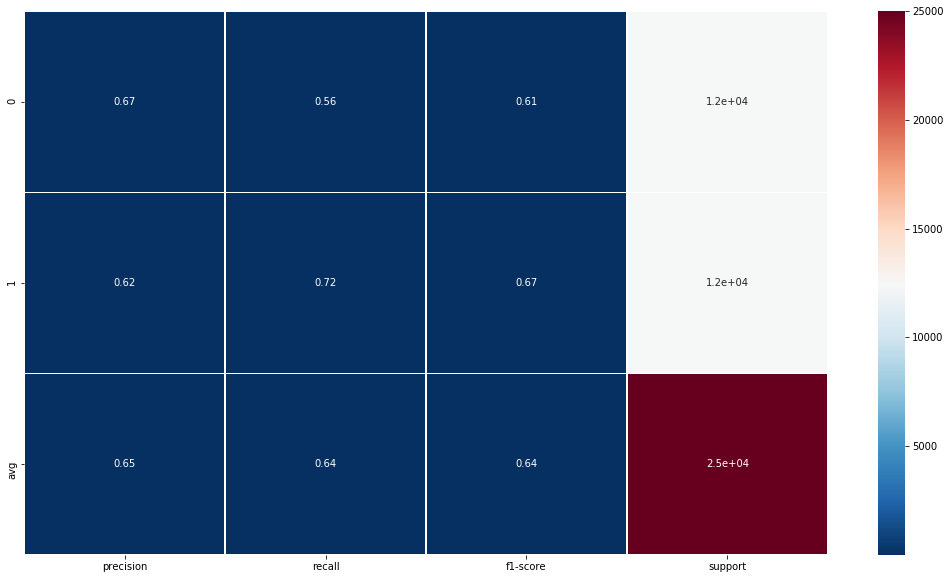

In [0]:
plot_classification_report(y_test, p3_classes)

### Vstack outputs

The vstack() function is used to stack arrays in sequence vertically (row wise).
This is equivalent to concatenation along the first axis after 1-D arrays of shape (N,) have been reshaped to (1,N).

![alt text](https://doc-0g-88-docs.googleusercontent.com/docs/securesc/v903qu5s530pc8ikhnbi48s9q8im2q6p/8403bus6cg8e6j2kkh3902lpca0th0n4/1578045600000/06997921430171725257/06997921430171725257/1FmktZYVa9-jdWonnie-3zlpJYqk6O1Kn?authuser=0)

In [0]:
concatenate_train = np.vstack([pred_ls_model_1,pred_ls_model_2,pred_lsA_model])

#### Logistic Regression (aka logit, MaxEnt) classifier.

In the multiclass case, the training algorithm uses the one-vs-rest (OvR) scheme if the ‘multi_class’ option is set to ‘ovr’, and uses the cross-entropy loss if the ‘multi_class’ option is set to ‘multinomial’. (Currently the ‘multinomial’ option is supported only by the ‘lbfgs’, ‘sag’, ‘saga’ and ‘newton-cg’ solvers.)

This class implements regularized logistic regression using the ‘liblinear’ library, ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ solvers. Note that regularization is applied by default. It can handle both dense and sparse input. Use C-ordered arrays or CSR matrices containing 64-bit floats for optimal performance; any other input format will be converted (and copied).

The ‘newton-cg’, ‘sag’, and ‘lbfgs’ solvers support only L2 regularization with primal formulation, or no regularization. The ‘liblinear’ solver supports both L1 and L2 regularization, with a dual formulation only for the L2 penalty. The Elastic-Net regularization is only supported by the ‘saga’ solver.

Read more in the User Guide:
    
#### ref: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

## Impelementation Stacking

In [0]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

lr_model = lr.fit(concatenate_train.T,Y_target.reshape(-1,1))

C:\Python\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Python\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
p1p2p3=np.vstack([p1_probs.T,p2_probs.T,p3_probs.T]).T

In [0]:
pred_test=lr_model.predict(p1p2p3)

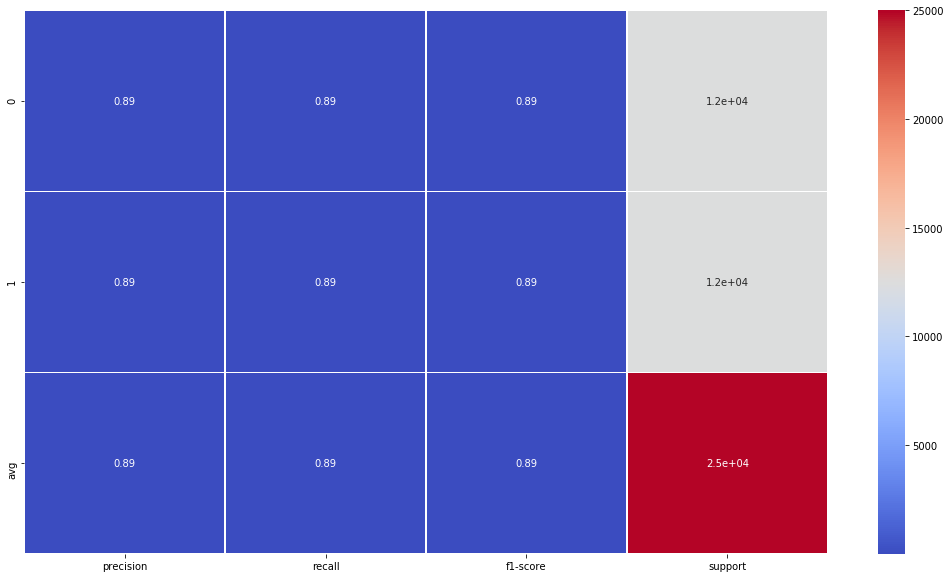

In [0]:
plot_classification_report(y_test,pred_test,cmap='coolwarm')

### Calculate Accuracy Stacking

In [0]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test,pred_test)
print('Accuracy of Stacking : %f' % accuracy)

## Final check accuracy all model

In [0]:
accuracy_p1_classes = accuracy_score(y_test, p1_classes)
accuracy_p2_classes = accuracy_score(y_test, p2_classes)
accuracy_p3_classes = accuracy_score(y_test, p3_classes)
accuracy_Stack = accuracy_score(y_test,pred_test)

In [0]:
dic = {'Model' : ['Stacking','Text_CNN','LSTM','LSTM_Attention'],
      'Accuracy': [accuracy_Stack,accuracy_p1_classes,accuracy_p2_classes,accuracy_p3_classes]}

df = pd.DataFrame(dic)
df.head()

,Model,Accuracy
0,Stacking,0.88908
1,Text_CNN,0.88092
2,LSTM,0.85668
3,LSTM_Attention,0.64120


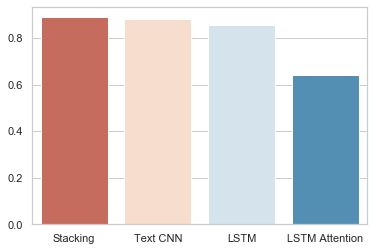

In [0]:
xticks = ['Stacking','Text CNN', 'LSTM', 'LSTM Attention']
yticks = [accuracy_Stack,accuracy_p1_classes,accuracy_p2_classes,
accuracy_p3_classes]

sns.set(style="whitegrid")
ax = sns.barplot(x=xticks, y=yticks,palette="RdBu")